In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [372]:
import dali.core as D
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from dali.models import MLP
from dali.utils import Solver
from IPython.display import clear_output, display, HTML
from sympy.geometry import Point, Circle, Segment, Polygon

import svg

from event_queue import EventQueue
from geometry import point_distance, point_projected_on_line, point_segment_distance

In [3]:
D.config.default_device = 'cpu'

In [81]:
from collections import deque

class DeepQ(object):
    def __init__(self, observation_size,
                       num_actions,
                       observation_to_actions,
                       solver,
                       random_action_probability=0.05,
                       exploration_period=1000,
                       minibatch_size=30,
                       discount_rate=0.95,
                       max_experience=20000):
        """Initialized the Deepq object.
        
        Based on:
            https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf
            
        Parameters
        -------
        observation_size : int
            length of the vector passed as observation
        num_actions : int
            number of actions that the model can execute
        observation_to_actions: dali model
            model that implements activate function
            that can take in observation vector or a batch
            and returns scores (of unbounded values) for each
            action for each observation.
            input shape:  [batch_size, observation_size]
            output shape: [batch_size, num_actions]
        solver: dali solver
            solver over observation_to_actions,
            must implement the step function
        random_action_probability: float (0 to 1)
        exploration_period: int
            probability of choosing a random 
            action (epsilon form paper) annealed linearly
            from 1 to random_action_probability over
            exploration_period
        minibatch_size: int
            number of state,action,reward,newstate
            tuples considered during experience reply
        dicount_rate: float (0 to 1)
            how much we care about future rewards.
        max_experience: int
            maximum size of the reply buffer
        """
        # memorize arguments
        self.observation_size          = observation_size
        self.num_actions               = num_actions
        
        self.observation_to_actions    = observation_to_actions
        self.solver                    = solver
        
        self.random_action_probability = random_action_probability
        self.exploration_period        = exploration_period
        self.minibatch_size            = minibatch_size
        self.discount_rate             = discount_rate
        self.max_experience            = max_experience
        
        # deepq state
        self.actions_executed_so_far = 0
        self.experience = deque()
        
    def linear_annealing(self, n, total, p_initial, p_final):
        """Linear annealing between p_initial and p_final
        over total steps - computes value at step n"""
        if n >= total:
            return p_final
        else:
            return p_initial - (n * (p_initial - p_final)) / (total)

    def activate(self, observation):
        """Given observation or a batch returns action scores."""
        action_scores = self.observation_to_actions.activate(observation)
        assert action_scores.shape[1] == self.num_actions, \
                "number of columns in the output of `observation_to_actions` must be equal to number of actions."
        assert action_scores.shape[0] == observation.shape[0], \
                "number of output rows of `observation_to_actions` must be equal to number of input rows"
        return action_scores
    
    def action(self, observation):
        """Given observation returns the action that should be chosen using
        DeepQ learning strategy. Does not backprop."""
        assert len(observation.shape) == 1, \
                "Action is performed based on single observation."

        self.actions_executed_so_far += 1
        exploration_p = self.linear_annealing(self.actions_executed_so_far,
                                              self.exploration_period,
                                              1.0,
                                              self.random_action_probability)
                                                 
        if random.random() < exploration_p:
            return random.randint(0, self.num_actions - 1)
        else:
            with D.NoBackprop():
                observation_dali = D.Mat(observation[np.newaxis,:], constant=True)
                assert observation_dali.shape == (1, observation.shape[0])
                action_scores = self.activate(observation_dali)
                return D.MatOps.argmax(action_scores, axis=1)[0]
        
    def store(self, observation, action, reward, newobservation):
        """Store experience, where starting with observation and
        execution action, we arrived at the newobservation and got the
        reward reward
        
        If newstate is None, the state/action pair is assumed to be terminal
        """
        self.experience.append((observation, action, reward, newobservation))
        if len(self.experience) > self.max_experience:
            self.experience.popleft()
    
    def training_step(self):
        """Pick a self.minibatch_size exeperiences from reply buffer
        and backpropage the value function.
        """
        if len(self.experience) <  self.minibatch_size:
            return
        
        # sample experience. 
        samples   = random.sample(range(len(self.experience)), self.minibatch_size)
        samples   = [self.experience[i] for i in samples]
        
        # bach states
        states    = np.empty((len(samples), self.observation_size))
        newstates = np.empty((len(samples), self.observation_size))
        action_mask    = np.zeros((len(samples), self.num_actions))
        
        newstates_mask = np.empty((len(samples),))
        rewards        = np.empty((len(samples),))
        
        for i, (state, action, reward, newstate) in enumerate(samples):
            states[i] = state
            action_mask[i] = 0
            action_mask[i][action] = 1
            rewards[i] = reward
            if newstate is not None:
                newstates[i] = state
                newstates_mask[i] = 1
            else:
                newstates[i] = 0
                newstates_mask[i] = 0
                
        # convert to dali, steal numpy memory, do not compute gradient (that's constant)
        states      = D.Mat(states,      borrow=True, constant=True)
        newstates   = D.Mat(newstates,   borrow=True, constant=True)
        action_mask = D.Mat(action_mask, borrow=True, constant=True)
        
        # compute target value functions
        with D.NoBackprop():
            action_scores = self.activate(newstates)
        # rowwise max - best achievable value function for each sample.
        newstates_value = action_scores.w.max(axis=1) * newstates_mask
        targets = rewards + self.discount_rate * newstates_value

        # convert to dali, steal numpy memory, do not compute gradient (that's constant)
        targets     = D.Mat(targets,     borrow=True, constant=True)
        
        # this computation will be backpropagated.
        action_scores = self.activate(states)
        relevant_actions = (action_scores * action_mask).sum(axis=1)
        error = (relevant_actions - targets)**2
        error.grad()
        
        # compute gradient
        D.Graph.backward()
        # apply gradient
        solver.step()    

In [335]:
from collections import defaultdict

class GameObject(object):
    def __init__(self, position, speed, obj_type, settings):
        """Esentially represents circles of different kinds, which have
        position and speed."""
        self.settings = settings
        self.radius = self.settings["object_radius"]
        
        self.obj_type = obj_type
        self.position = np.array(position, dtype=float)
        self.speed = np.array(speed, dtype=float)
        
    def wall_collisions(self):
        """Update speed upon collision with the wall."""
        world_size = self.settings["world_size"]
        for dim in range(2):
            if self.position[dim] - self.radius       <= 0               and self.speed[dim] < 0:
                self.speed[dim] = - self.speed[dim]
            elif self.position[dim] + self.radius + 1 >= world_size[dim] and self.speed[dim] > 0:
                self.speed[dim] = - self.speed[dim]
        
    def move(self, dt):
        """Move as if dt seconds passed"""
        self.position += dt * self.speed
        
    def step(self, dt):
        """Move and bounce of walls."""
        self.wall_collisions()
        self.move(dt)
        
    def draw(self):
        """Return svg object for this item."""
        color = self.settings["colors"][self.obj_type]
        return svg.Circle(self.position.astype(int) + 10, self.radius, color=color)

class KarpathyGame(object):
    def __init__(self, settings):
        """Initiallize game simulator with settings"""
        self.settings = settings
        self.size = np.array(self.settings["world_size"])
        
        self.hero = GameObject(self.settings["hero_initial_position"].copy(),
                               self.settings["hero_initial_speed"].copy(),
                               "hero",
                               self.settings)
        
        self.objects = []
        for obj_type, number in settings["num_objects"].items():
            for _ in range(number):
                self.spawn_object(obj_type)
        
        self.observation_lines = self.generate_observation_lines()
                
        self.object_reward = 0
        self.collected_rewards = []
        
        # every observation_line sees one of objects or wall and
        # two numbers representing speed of the object (if applicable)
        # and one number representing proximity
        self.eye_observation_size = len(self.settings["objects"]) + 4
        # additionally there are two numbers representing agents own speed.
        self.observation_size = self.eye_observation_size * len(self.observation_lines) + 2
        
        self.directions = [np.array(d) for d in [[1,0], [0,1], [-1,0],[0,-1]]]
        self.num_actions      = len(self.directions)
        
        self.objects_eaten = defaultdict(lambda: 0)
        
    def perform_action(self, action_id):
        """Change speed to one of hero vectors"""
        assert 0 <= action_id < self.num_actions
        self.hero.speed *= 0.95
        self.hero.speed += self.directions[action_id] * self.settings["delta_v"]
            
    def spawn_object(self, obj_type):
        """Spawn object of a given type and add it to the objects array"""
        radius = self.settings["object_radius"]
        position = np.random.uniform([radius, radius], self.size - radius).astype(float)
        speed    = np.random.uniform([-100,-100], [100,100]).astype(float)
        self.objects.append(GameObject(position, speed, obj_type, self.settings))     
                
    def step(self, dt):
        """Simulate all the objects for a given ammount of time.
        
        Also resolve collisions with the hero"""
        for obj in self.objects + [self.hero] :
            obj.step(dt)
        self.resolve_collisions()

    def resolve_collisions(self):
        """If hero touches, hero eats. Also reward gets updated."""
        to_remove = []
        for obj in self.objects:
            if np.linalg.norm(obj.position - self.hero.position) < 2 * self.settings["object_radius"]:
                to_remove.append(obj)
        for obj in to_remove:
            self.objects.remove(obj)
            self.objects_eaten[obj.obj_type] += 1
            self.object_reward += self.settings["object_reward"][obj.obj_type]
            self.spawn_object(obj.obj_type)
        
    def inside_walls(self, point):
        """Check if the point is inside the walls"""
        return np.all(np.array([0,0]) <= point) and np.all(point < self.size)
        
    def observe(self):
        """Return observation vector. For all the observation directions it returns representation
        of the closest object to the hero - might be nothing, another object or a wall.
        Representation of observation for all the directions will be concatenated.
        """
        num_obj_types = len(self.settings["objects"]) + 1 # and wall

        observable_distance = self.settings["object_radius"] + self.settings["observation_line_length"]
        relevant_objects = [obj for obj in self.objects 
                            if point_distance(obj.position, self.hero.position) < observable_distance]
        # objects sorted from closest to furthest
        relevant_objects.sort(key=lambda x: point_distance(x.position, self.hero.position))
        
        observation        = np.zeros(self.observation_size)
        observation_offset = 0 
        for i, (line_start, line_end) in enumerate(self.observation_lines):
            line_start = line_start + self.hero.position
            line_end   = line_end   + self.hero.position
            observed_object = None
            if not self.inside_walls(line_end):
                observed_object = "**wall**"
            for obj in relevant_objects:
                if point_segment_distance(line_start, line_end, obj.position) < SETTINGS["object_radius"]:
                    observed_object = obj
                    break
            object_type_id = None
            speed_x, speed_y = 0, 0
            proximity = 0
            if observed_object == "**wall**": # wall seen 
                object_type_id = num_obj_types - 1
                # wall has a fairly low speed of movement...
                speed_x, speed_y = 0, 0
                # TODO: line below is not entirely correct
                # different eyes can see different distance
                proximity = self.distance_to_walls()
            elif observed_object is not None: # agent seen
                object_type_id = self.settings["objects"].index(observed_object.obj_type)
                speed_x, speed_y = observed_object.speed
                print (self.hero.position, obj.position)
                proximity = max(point_distance(self.hero.position, obj.position)
                                - 2.0 * self.settings["object_radius"], 0)
                print(proximity)
            if object_type_id is not None:
                observation[observation_offset + object_type_id] = 1
            observation[observation_offset + num_obj_types] = speed_x
            observation[observation_offset + num_obj_types + 1] = speed_y
            observation[observation_offset + num_obj_types + 2] = proximity
            assert num_obj_types + 3 == self.eye_observation_size
            observation_offset += self.eye_observation_size
        
        observation[observation_offset]     = self.hero.speed[0]
        observation[observation_offset + 1] = self.hero.speed[1]
        assert observation_offset + 2 == self.observation_size
        
        return observation        
    
    def distance_to_walls(self):
        """Returns distance of a hero to walls"""
        tl = np.min(self.hero.position - self.settings["object_radius"])
        br = np.min(self.size - self.hero.position - self.settings["object_radius"])
        return np.min([tl,br])
        
    def collect_reward(self):
        """Return accumulated object eating score + current distance to walls score"""
        wall_reward =  self.settings["wall_distance_penalty"] * \
                       np.exp(-self.distance_to_walls() / self.settings["tolerable_distance_to_wall"])
        total_reward = wall_reward + self.object_reward
        self.object_reward = 0
        self.collected_rewards.append(total_reward)
        return total_reward
        
    def plot_reward(self, smoothing = 30):
        """Plot evolution of reward over time."""
        plottable = self.collected_rewards[:]
        while len(plottable) > 1000:
            for i in range(0, len(plottable) - 1, 2):
                plottable[i//2] = (plottable[i] + plottable[i+1]) / 2
            plottable = plottable[:(len(plottable) // 2)]
        x = []
        for  i in range(smoothing, len(plottable)):
            chunk = plottable[i-smoothing:i]
            x.append(sum(chunk) / len(chunk))
        plt.plot(list(range(len(x))), x)
        
    def generate_observation_lines(self):
        """Generate observation segments in settings["num_observation_lines"] directions"""
        result = []
        start = np.array([self.settings["object_radius"]* 1.1, self.settings["object_radius"]* 1.1])
        end   = np.array([self.settings["object_radius"] + self.settings["observation_line_length"],
                          self.settings["object_radius"] + self.settings["observation_line_length"]])
        for angle in np.linspace(0, 2*np.pi, self.settings["num_observation_lines"], endpoint=False):
            rotation = np.array([np.cos(angle), np.sin(angle)])
            result.append((start * rotation, end * rotation))
        return result
        
    def _repr_html_(self):
        return self.to_html()
    
    def to_html(self, stats):
        """Return svg representation of the simulator"""
        scene = svg.Scene((self.size[0] + 20, self.size[1] + 20 + 20 * len(stats)))
        scene.add(svg.Rectangle((10, 10), self.size))
        for obj in self.objects + [self.hero] :
            scene.add(obj.draw())
            
        for line_start, line_end in self.observation_lines:
            scene.add(svg.Line(line_start + self.hero.position + 10, line_end + self.hero.position + 10))
        
        offset = self.size[1] + 15
        for txt in stats:              
            scene.add(svg.Text((10, offset + 20), txt, 15))
            offset += 20
                          
        return scene
        

In [311]:
SETTINGS = {
    'objects': [
        'friend',
        'enemy',
#         'boss'
    ],
    'colors': {
        'hero':   'yellow',
        'friend': 'green',
        'enemy':  'red',
#         'boss':   'orange',
    },
    'object_reward': {
        'friend': 5,
        'enemy': -5,
#         'boss':  -20,
    },
    'world_size': (800,600),
    'hero_initial_position': [400, 300],
    'hero_initial_speed':    [0, 0],
    "object_radius": 10,
    "num_objects": {
        "friend" : 10,
        "enemy" :  10,
#         "boss" :   5,
    },
    "num_observation_lines" : 32,
    "observation_line_length": 100,
    "tolerable_distance_to_wall": 50,
    "wall_distance_penalty":  0.1,
    "delta_v": 40
}

In [312]:
# create the game simulator
g = KarpathyGame(SETTINGS)

In [313]:
# brain maps from observation to action q values. Here it is a simple mlp
brain = MLP([g.observation_size,], [200, 100, g.num_actions], [D.MatOps.tanh, D.MatOps.tanh, lambda x: x])
# solver over brian - here simple sgd
# solver = Solver(brain.parameters(), "rmsprop", learning_rate= 0.005, decay_rate = 0.999, smooth_eps = 1e-8;)
solver = Solver(brain.parameters(), "sgd", learning_rate= 0.01)
# DeepQ object
c = DeepQ(g.observation_size, g.num_actions, brain, solver, exploration_period=5000, max_experience=30000)

In [316]:
def simulate(game,
             controller,
             fps=60,
             actions_per_second=60,
             simulation_resultion=0.001,
             speed=1.0,
             store_every_nth=5):
    """Start the simulation. Performs three tasks
       
        - visualizes simulation in iPython notebook
        - advances game simulator state
        - reports state to controller and chooses actions
          to be performed.
    """
    eq = EventQueue()
    
    time_between_frames  = 1.0 / fps
    time_between_actions = 1.0 / (actions_per_second * speed)
    
    def visualize():
        clear_output(wait=True)
        recent_reward = game.collected_rewards[-100:] + [0]
        objects_eaten_str = ', '.join(["%s: %s" % (o,c) for o,c in game.objects_eaten.items()])
        display(game.to_html([
            "DTW        = %.1f" % (game.distance_to_walls(),),
            "experience = %d" % (len(controller.experience),),
            "reward = %.1f" % (sum(recent_reward)/len(recent_reward),),
            "objects eaten => %s" % (objects_eaten_str,),

        ]))
    eq.schedule_recurring(visualize, time_between_frames)
        
    simulated_up_to = time.time()

    def simulate_game():
        nonlocal simulated_up_to
        now = time.time()
        time_to_be_simulated = speed * (now - simulated_up_to)
        for _ in range(int(time_to_be_simulated / simulation_resultion)):
            game.step(simulation_resultion)
        simulated_up_to = now
        
    eq.schedule_recurring(simulate_game, min(time_between_frames, time_between_actions))

    
    last_observation = None
    last_action      = None
    actions_so_far = 0
    
    def control():
        nonlocal last_observation
        nonlocal last_action
        nonlocal actions_so_far
        # sense
        new_observation = game.observe()
        reward          = game.collect_reward()
        # store last transition
        actions_so_far += 1
        if last_observation is not None and actions_so_far % store_every_nth == 0:
            controller.store(last_observation, last_action, reward, new_observation)
        # act
        new_action = controller.action(new_observation)
        game.perform_action(new_action)
        last_action = new_action
        last_observation = new_observation
        
        #train
        controller.training_step()
        
    
    eq.schedule_recurring(control, time_between_actions)
    
    eq.run()
    


In [336]:
g.__class__ = KarpathyGame
np.set_printoptions(formatter={'float': (lambda x: '%.2f' % (x,))})
x = g.observe()
new_shape = (x[:-2].shape[0]//g.eye_observation_size, g.eye_observation_size)
x[:-2].reshape(new_shape)

[775.67 125.34] [693.17 165.07]
71.5670231046


array([[0.00, 0.00, 1.00, 0.00, 0.00, 14.33],
       [0.00, 0.00, 1.00, 0.00, 0.00, 14.33],
       [0.00, 0.00, 1.00, 0.00, 0.00, 14.33],
       [0.00, 0.00, 1.00, 0.00, 0.00, 14.33],
       [0.00, 0.00, 1.00, 0.00, 0.00, 14.33],
       [0.00, 0.00, 1.00, 0.00, 0.00, 14.33],
       [0.00, 0.00, 1.00, 0.00, 0.00, 14.33],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 1.00, 0.00, 25.44, -29.51, 71.57],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00],

In [321]:
simulate(g, c, fps = 30, simulation_resultion=0.01, actions_per_second=10, speed=0.5, store_every_nth=3)

KeyboardInterrupt: 

In [ ]:
g

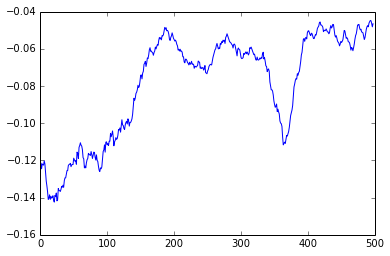

In [295]:
g.plot_reward()

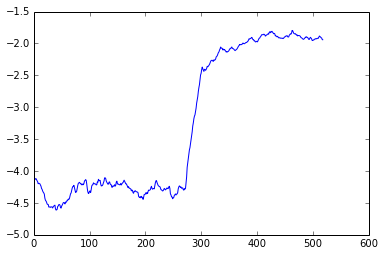

In [77]:
g.plot_reward()

In [331]:
x = np.array([775.67, 125.34])
y = np.array([693.17, 165.07])

np.sqrt(sum((x - y)**2))

91.568132557129275

In [333]:
SETTINGS["object_radius"]

10

In [334]:
point_distance(x,y)

91.568132557129275

In [342]:
t = Point(3.41312321321321,4.1234123421342134) + Point(1,2.55132413243214321432143214)

In [345]:
float(t.x)

4.41312321321321

In [349]:
c = Circle(Point(0,0), 2)

In [351]:
s = Segment(Point(0,0), Point(4,4))

In [363]:
(c.intersection(s)[0] + Point(1,1))/ 4 + Point(1,1) / 4

Point(sqrt(2)/4 + 1/2, sqrt(2)/4 + 1/2)

In [366]:
Point(-1,-1) in Polygon(Point(0,0), Point(0,1), Point(1,1), Point(1,0))

False

In [367]:
Point(-1,-1).distance(s)

ValueError: Only two dimensional points currently supported

In [370]:
s.distance(Point(-1,-1))

sqrt(2)